# CHARDA - Charge determination analysis

In [1]:
import numpy as np
from numpy.fft import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors
import pandas as pd
import scipy.signal as ss
from scipy import stats
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy import interpolate
from pyopenms import * 
from configobj import ConfigObj
import subprocess
import os
import IsoSpecPy
import h5py
import jdc
import warnings
from pandas.core.common import SettingWithCopyWarning
from tqdm.notebook import trange, tqdm

%matplotlib inline

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
C13_Shift=1.0033548
Proton=1.0072764666

# Transient spectrum class 

## Init and clean up

In [4]:
class TransSpectrum:
    def __init__(self, TransData, name="Spectrum", build=True):
        self.trans = TransData
        self.name = name
        self.QuantFreq=3906250.0
        self.__A=2.11763959697e+14
        self.InitDeps()
        if build :
            self.MakeSpectrum()
            self.HalfSpecs()
            
    #Charnge calibration constant
    @property 
    def A(self):
        return self.__A
    
    @A.setter
    def A(self,A):
        self.__A=A
        self.InitDeps()
        self.MakeSpectrum()
        self.HalfSpecs()
        
    #initialize dependent arrays and variables
    def InitDeps(self):
        #Length of transient
        self.TrLen = len(self.trans)
        #Apodization arrays 
        #For full spectrum 
        self.KaiserArray=np.kaiser(self.TrLen,np.pi*3)
        #For half spectrum 
        self.KaiArray2=np.kaiser(self.TrLen//2,np.pi*3) #may migrate to half arrays
        #calibration array
        cscale=np.arange(self.TrLen)
        cscale[0]=1 #to avoid division by zero
        self.calib=self.A/np.square(cscale/(self.TrLen/self.QuantFreq))
        self.spaceX=np.linspace(800500.,3999500.,3200)
        
    def declb(self, mass):
        return (np.sqrt(self.A)*self.TrLen)/(np.sqrt(mass)*self.QuantFreq)

## Make spectrum

In [5]:
%%add_to TransSpectrum
def MakeSpectrum(self):
    self.SpecKai=fft(self.trans*self.KaiserArray)
    self.MagnKai=np.sqrt(self.SpecKai.real*self.SpecKai.real+self.SpecKai.imag*self.SpecKai.imag)

In [6]:
%%add_to TransSpectrum
def HalfSpecs(self):
    tr1=self.trans[:len(self.trans)//2]*self.KaiArray2
    tr2=self.trans[len(self.trans)//2:]*self.KaiArray2
    sp1=fft(tr1)
    sp2=fft(tr2)
    self.m1=np.sqrt(sp1.real*sp1.real+sp1.imag*sp1.imag)
    self.m2=np.sqrt(sp2.real*sp2.real+sp2.imag*sp2.imag)

In [7]:
%%add_to TransSpectrum
def SaveTransient(self, FileName):
    tfile=open(FileName,"w")
    tfile.write("{}\n".format(self.A))
    tfile.write("{}\n".format(self.QuantFreq))
    np.savetxt(tfile,self.trans,fmt="%f")
    tfile.close()

## Display Spectra

In [8]:
%%add_to TransSpectrum
def plotmasskai(self, minMass,maxMass,*args,PlotTo=None,labels=[],fname=None):
    if PlotTo is None:
        fig, ax = plt.subplots()
    else:
        ax = PlotTo
    #ax.get_xaxis().get_major_formatter().set_useOffset(False)
    #ax.get_yaxis().get_major_formatter().set_useOffset(False)
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
    ax.locator_params(axis='x',nbins=6)
    ax.set_xlabel("m/z")
    ax.set_ylabel("Abundance, orb. units")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)        
    ax.plot(self.calib[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1],
            self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1],*args)
    #ax.plot(calib[int(np.round(declb(maxMass))):int(np.round(declb(minMass)))+1],
    #        MagnKai_std[int(np.round(declb(maxMass))):int(np.round(declb(minMass)))+1],*args)
    if len(labels)>0 :
        for mz,n in labels:
            if type(n)==float:
                ax.annotate("{:.2f}".format(n),(mz,self.MagnKai[int(np.round(self.declb(mz)))]),textcoords="offset points",xytext=(0,10),ha='center' )
            else:    
                ax.annotate(n,(mz,self.MagnKai[int(np.round(self.declb(mz)))]),textcoords="offset points",xytext=(0,10),ha='center' )
    if fname is not None:
        plt.savefig(fname)
    if PlotTo is None:
        plt.show()
        return plt
    else:
        return PlotTo

## Process Spectrum

In [9]:
%%add_to TransSpectrum
def spratio(self,center,points):
    centerf=int(np.round(((np.sqrt(self.A)*len(self.m1))/(np.sqrt(center)*self.QuantFreq))))
    minsp=centerf-points
    maxsp=centerf+points
    s1sum=np.sum(self.m1[minsp:maxsp+1])
    s2sum=np.sum(self.m2[minsp:maxsp+1])
    return s1sum/s2sum               

## Processing Functions

### Spectra and peaks

In [10]:
%%add_to TransSpectrum
def PeakPick(self,minMass,maxMass,sn=1.):
    self.peaks = None
    pp=PeakPickerHiRes()
    par=pp.getParameters()
    par.setValue('report_FWHM','true')
    par.setValue('signal_to_noise',sn)
    pp.setParameters(par)
    spectrum=MSSpectrum()
    spectrum.set_peaks([np.flip(self.calib[int(self.declb(maxMass)):int(self.declb(minMass))]),
                        np.flip(self.MagnKai[int(self.declb(maxMass)):int(self.declb(minMass))])])
    picked=MSSpectrum()
    pp.pick(spectrum, picked)
    #FWHM in ppms
    fda=picked.getFloatDataArrays()
    #mzs, intensities
    ppmz,ppints = picked.get_peaks()
    self.peaks=pd.DataFrame({"m/z":ppmz,"Intensity":ppints,"resolution":1000000./fda[0].get_data()})
    #return self.peaks

### Hardklor and products

In [29]:
class FullSpectrum(TransSpectrum):
    def RunHardKlor(self, **kwargs):
        hkconf=ConfigObj("hardklor_dump.conf")
        for key, value in kwargs.items():
            hkconf[key]=value
        newhkconf=open("hardklor.conf","wb") 
        hkconf.write(newhkconf)
        newhkconf.write("temp.mzXML /code/temp.hk".encode("ascii"))
        newhkconf.close()
        spectrum=MSSpectrum()
        spectrum.set_peaks([np.array(self.peaks["m/z"]),np.array(self.peaks["Intensity"])])
        spectrum.setMSLevel(1)
        spectrum.setRT(1.0)
        spectrum.setName("1")
        spectrum.setType(2)
        spectrum.updateRanges()
        exp=MSExperiment()
        exp.addSpectrum(spectrum)
        mzFile=MzXMLFile()
        Options=mzFile.getOptions()
        Options.setForceMQCompatability(True)
        mzFile.setOptions(Options)
        mzFile.store("temp.mzXML",exp)
        subprocess.run(["./hardklor","hardklor.conf"])
        self.Clusters=pd.read_csv("temp.hk",sep="\t",skiprows=1,names=["Mass","Charge","Abundance","Base Peak","Interval","Correlation"],
                        usecols=[1,2,3,4,5,8])
        #return self.Clusters
    

In [12]:
def IonProducts(Clusters, sequence=None, ppm=10,Shift=0):
    Clusters["Ions"]=""
    Clusters["PPMError"]=0.
    Clusters["Shift"]=0
    Clusters["TheorMass"]=0.
    if isinstance(sequence,str):
        sequence=AASequence.fromString(sequence)
    ProductLabels=["a","b","c","x","y","z"]
    coverSet=[[]]*(sequence.size()-1)
    for i in range(1,sequence.size()-1):
        bpart=sequence.getPrefix(i)
        ypart=sequence.getSuffix(i)
        amass=bpart.getMonoWeight(Residue.ResidueType.AIon,0)
        bmass=bpart.getMonoWeight(Residue.ResidueType.BIon,0)
        cmass=bpart.getMonoWeight(Residue.ResidueType.CIon,0)
        xmass=ypart.getMonoWeight(Residue.ResidueType.XIon,0)
        ymass=ypart.getMonoWeight(Residue.ResidueType.YIon,0)
        zmass=ypart.getMonoWeight(Residue.ResidueType.ZIon,0)
        products=[amass,bmass,cmass,xmass,ymass,zmass]
        for label,product in zip(ProductLabels,products):
            for Sh in range(-Shift,Shift+1):
                Target=Clusters[Clusters["Mass"].between(product+Sh*1.003355-(product*ppm/1000000),product+Sh*1.003355+(product*ppm/1000000))]
                for row in Target.iterrows():
                    Clusters.at[row[0],"Ions"]="{}{}".format(label,i)
                    Clusters.at[row[0],"PPMError"]=(Clusters.at[row[0],"Mass"]-product-Sh*1.003355)*1000000./product
                    Clusters.at[row[0],"Shift"]=Sh
                    Clusters.at[row[0],"TheorMass"]=product
                    if label<"d":
                        #print("{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"]))
                        coverSet[i]=coverSet[i]+["{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"])]
                    else:
                        coverSet[sequence.size()-i]=coverSet[sequence.size()-i]+["{}{} {}+".format(label,i,Clusters.at[row[0],"Charge"])]
    counter=0
    for i in range(sequence.size()-1):
        if len(coverSet[i])>0 :
            counter += 1
    cover=counter/(sequence.size()-1)
    return Clusters,coverSet,cover

In [13]:
%%add_to FullSpectrum
def Products(self, sequence=None, ppm=10,Shift=0):
    if sequence is None :
        sequence = self.sequence
    self.sequence = sequence
    self.Clusters,coverSet,cover = IonProducts(self.Clusters,self.sequence,ppm,Shift)
    return self.Clusters,coverSet,cover
    

### Filtering and joining

In [14]:
%%add_to TransSpectrum
def CheckIssues(self):
    self.peaks["issues"]=False
    for i in range(len(self.peaks)):
        mz=self.peaks.loc[i]["m/z"]
        margin=self.calib[int(self.declb(mz))]-self.calib[int(self.declb(mz))+5]
        diff=0
        for j in range(i-1,0,-1):
            diff=self.peaks.loc[i]["m/z"]-self.peaks.loc[j]["m/z"]
            if diff>margin :
                break
            if self.peaks.loc[i]["Intensity"]/self.peaks.loc[j]["Intensity"]<5.0 :
                margin=diff/2.0
                self.peaks.at[i,'issues']=True
        for j in range(i+1,len(self.peaks)):
            diff=self.peaks.loc[j]["m/z"]-self.peaks.loc[i]["m/z"]
            if diff>margin :
                break
            if self.peaks.loc[i]["Intensity"]/self.peaks.loc[j]["Intensity"]<5.0 :
                margin=diff/2.0
                self.peaks.at[i,'issues']=True
    return self.peaks
    #peaks.at[i,'left']=peaks.loc[i]['m/z']-margin        
    #peaks.at[i,'right']=peaks.loc[i]['m/z']+margin            

In [15]:
%%add_to FullSpectrum
def PeakstoClusters(self):
    links = 0
    counter=0
    for row in self.Clusters.iterrows():
        #10 ppm acceptable error
        ppms=row[1]["Base Peak"]/100000
        #take peaks in 5 Da interval from MonoMZ (plus errors)
        IntervPair=row[1].Interval.split('-')
        localpeak=self.peaks[(self.peaks['m/z']>float(IntervPair[0])-ppms) & (self.peaks['m/z']<float(IntervPair[1])+ppms)]
        #Mass difference to monoisotopic mass (not m/z!)
        localpeak["rest"]=(localpeak['m/z']-Proton)*row[1].Charge-row[1].Mass
        #Isotope number
        localpeak["Number"]=np.round(localpeak["rest"]/C13_Shift).astype(int)
        #Mass shift from nearest isotope
        localpeak.loc[:,["rest"]]=localpeak["rest"]-np.round(localpeak["rest"])*C13_Shift
        #Only peaks in acceptible error range from nearest Isotope allowed
        localpeak=localpeak[np.abs(localpeak['rest'])<ppms*row[1].Charge]
        #try to select consequent peaks
        toGet=[]
        #looking for consequtive peaks where most intense for isotope the same as most accurate 
        #high mass clusters (mass>20000) could be lost of low intensity first peaks
        #processed from maximum peak back and forth - stops when intensity is growing 
        #most abundant isotope number 
        start=int((row[1]["Base Peak"]-Proton)*row[1]["Charge"]-row[1]["Mass"])
        #print(start)
        LastInt=1.e20
        #print(localpeak)
        for i in range(start,-1,-1):
            lp=localpeak[localpeak["Number"]==i]
            #if isotope is not found
            if len(lp) == 0 :
                break
            IntMax=lp["Intensity"].idxmax()
            RestMin=np.abs(lp["rest"]).idxmin()
            #if most accurate peak is not most intense
            if IntMax!=RestMin:
                break
            #if next peak is more abundant 
            if lp.loc[IntMax]["Intensity"]>1.3*LastInt:
                break
            LastInt=lp.loc[IntMax]["Intensity"]
            toGet.insert(0,IntMax)
        LastInt=1.e20
        for i in range(start,20):
            lp=localpeak[localpeak["Number"]==i]
            #if isotope is not found
            if len(lp) == 0 :
                break
            IntMax=lp["Intensity"].idxmax()
            RestMin=np.abs(lp["rest"]).idxmin()
            #if most accurate peak is not most intense
            if IntMax!=RestMin:
                break
            #if next peak is more abundant 
            if lp.loc[IntMax]["Intensity"]>1.3*LastInt:
                #print(lp.loc[IntMax]["Intensity"],LastInt)
                break
            LastInt=lp.loc[IntMax]["Intensity"]
            toGet.append(IntMax)
        toGet=list(set(toGet))
        toGet.sort()
        #print(toGet)
        if toGet is None :
            continue
        localpeak=localpeak.loc[toGet]
        link=pd.DataFrame({"cluster" :np.full(len(localpeak),row[0]),
                           "peak" : localpeak.index,
                           "number" : localpeak["Number"],
                           "rest" : localpeak["rest"],
                           "intensity" : localpeak["Intensity"]})
        #print(link)
        if isinstance(links,int) :
            links = link
        else:
            links=links.append(link)
        counter+=1
        #if counter>10:
            #break
    #print(links)
    self.links = links
    peaksref=self.peaks.join(self.links.set_index('peak'),how='inner')
    self.RPeaks=peaksref.join(self.Clusters,how='inner',on='cluster',lsuffix='_peak')    
    #return links

In [16]:
%%add_to FullSpectrum
def UsualProcessing(self):
    self.PeakPick(250,2500)
    self.CheckIssues()
    self.RunHardKlor(charge_min=1,charge_max=30)
    self.PeakstoClusters()

### Reverse FFT

In [17]:
%%add_to TransSpectrum
def taucalckai(self,minmass,maxmass,Print=False,Plot=None):
    arr=np.zeros(self.TrLen,dtype=np.complex)
    arr[int(np.round(self.declb(maxmass))):int(np.round(self.declb(minmass)))+1]=self.SpecKai[int(np.round(self.declb(maxmass))):int(np.round(self.declb(minmass)))+1]
    arr[int(np.round(-self.declb(minmass))):-int(np.round(self.declb(maxmass)))+1]=self.SpecKai[int(np.round(-self.declb(minmass))):int(np.round(-self.declb(maxmass)))+1]
    recsig=np.abs(ifft(arr)/self.KaiserArray)
    env=[np.average(recsig[int(i)-500:int(i+500)].real) for i in self.spaceX]
    s = stats.linregress(self.spaceX/self.QuantFreq,np.log(env))   
    if Print :
        if Plot is None:
            fig, ax = plt.subplots()
            ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1e'))
            ax.plot(self.spaceX/self.QuantFreq,env,label="signal envelope")#np.log(env))
            ax.plot(self.spaceX/self.QuantFreq,np.exp(s[0]*(self.spaceX/self.QuantFreq)+s[1]),label="exponent fit")
            ax.legend()
            plt.show()
        else:
            Plot.plot(self.spaceX/self.QuantFreq,np.log(env))
            Plot.plot(self.spaceX/self.QuantFreq,(self.spaceX/self.QuantFreq)*s[0]+s[1])
    return s

In [18]:
def FWHMCalc(Peaks):
    Peaks["FWHM"]=Peaks["m/z"]/Peaks["resolution"]
    Peaks["FWHM Coeff"]=np.power(Peaks["FWHM"],0.6666)/(Peaks["m/z"]*3.e-5)    
    return Peaks

In [19]:
%%add_to TransSpectrum
def TDACalc(self,Peaks=pd.DataFrame()):
    if Peaks.empty :
        Peaks = self.RPeaks
    
    Peaks["Slope"]=0.
    Peaks["Intercept"]=0.    
    Peaks["RSquare"]=0.
    Peaks["Ratio"]=0.0
    Peaks = FWHMCalc(Peaks)
    
    Peaks.reset_index(drop=True,inplace=True)


    for i in trange(len(Peaks)):
        center=int(np.round(self.declb(Peaks.iloc[i]["m/z"])))
        s=self.taucalckai(self.calib[center+5],self.calib[center-5])
        Peaks.at[i,"Slope"]=s[0]
        Peaks.at[i,"Intercept"]=s[1]    
        Peaks.at[i,"RSquare"]=s[2]
        Peaks.at[i,"Ratio"]=self.spratio(Peaks.iloc[i]['m/z'],5)
    return Peaks

### Show resolution

In [20]:
colors=["black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple",\
        "black","red","orange","xkcd:dandelion","lime","lightseagreen","dodgerblue","blue","purple"]

In [21]:
def ShowRes(Values,Charges,xlabel = "Predicted Charge",GaussianHeght=3,MinCharge=0,MaxCharge=0,fname=""):
    SigmaSum=0
    Counter=0
    if (MinCharge == 0):
        MinCharge = int(np.min(Charges))
    if (MaxCharge == 0):
        MaxCharge = int(np.max(Charges))
    MinValue = int(np.min(Values))
    MaxValue = np.max(Values)
    x = np.linspace(MinValue-(MaxValue-MinValue)/5.,MaxValue+(MaxValue-MinValue)/5.,200)
    print("Charge \tPeaks \t Mean \t Variance")
    for i in range(MinCharge,MaxCharge+1):
        Slopes=Values[Charges==i]
        if (len(Slopes)>=2):
            Params=stats.norm.fit(Slopes)
            print("{} \t{} \t{:6.3f} \t{:6.3f}".format(i,len(Slopes),Params[0],Params[1]))
            SigmaSum=SigmaSum+Params[1]
            Counter+=1
            fitted = stats.norm.pdf(x,loc = Params[0],scale = Params[1])
            fitted=(fitted/np.max(fitted))*GaussianHeght
            plt.plot(x,fitted,colors[i],label="Charge "+str(i)+" fit")
        plt.hist(Slopes,x,facecolor=colors[i],alpha=0.5)
    plt.legend()
    plt.xlabel(xlabel)
    if (fname!=""):
        plt.savefig(fname)
    SigmaAve=SigmaSum/Counter
    FWHM=SigmaAve*2.355
    Res=MaxCharge/FWHM
    #Res=(MaxValue-MinValue)/FWHM
    print("Resolution: {:.2f}".format(Res))

### Regression

In [22]:
class Regression:
    def __init__(self,FRes,NoMZ=False,FWHM=False,Slope=True):
        self.NoMZ=NoMZ
        self.FWHM=FWHM
        self.Slope=Slope 
        self.X=self.FeatureExtraction(FRes)
        self.Fit(self.X,FRes["Charge"])
        
    def FeatureExtraction(self,FRes):
        X=pd.DataFrame()
        if self.Slope:
            X["Slope"]=FRes["Slope"]
            X["SlopelogIntens"]=FRes["Slope"]*np.log(FRes["Intensity"])
        X["LogRatio"]=np.log(FRes["Ratio"])
        X["RatiologIntens"]=np.log(FRes["Ratio"])*np.log(FRes["Intensity"])
        if (not self.NoMZ):
            if self.Slope:
                X["SlopeMZ"]=FRes["Slope"]*FRes["m/z"]
            X["LogRatioMZ"]=np.log(FRes["Ratio"])*FRes["m/z"]
        if self.FWHM:
            X["FWHM"] = FRes["FWHM Coeff"]
        return X
    
    def Fit(self,X,Y):
        return
    
    def Apply(self,FRes):
        return
    

In [23]:
class LinearReg(Regression):
    
    def Fit(self,X,Y):
        self.regr=linear_model.LinearRegression()
        self.regr.fit(X,Y)

    def Apply(self,FRes):
        X=self.FeatureExtraction(FRes)
        Y_pred=self.regr.predict(X)
        return Y_pred        

In [24]:
def weighted_avg_and_std(values, weights):
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return average, np.sqrt(variance)

In [25]:
class LogisticReg(Regression):
    
    def __init__(self,FRes,NoMZ=False,FWHM=False,Slope=True,ClassThres=3):
        self.ClassThres = ClassThres
        Classes=np.sort(FRes["Charge"].unique())
        Enough=[ np.count_nonzero(FRes["Charge"]==n) >= ClassThres for n in Classes]
        self.Classes = Classes[Enough]
        FRes=FRes[np.isin(FRes["Charge"],self.Classes)]
        super().__init__(FRes,NoMZ,FWHM,Slope)
        
    def Fit(self,X,Y):
        self.scaler=StandardScaler()
        X_scaled=self.scaler.fit_transform(X)
        self.lr=LogisticRegression(solver="newton-cg" ,max_iter=100000, penalty="none")
        self.lr.fit(X_scaled,Y)
        
    def Apply(self,FRes):
        X=self.FeatureExtraction(FRes)
        X_scaled=self.scaler.transform(X)
        Y_distr=self.lr.predict_proba(X_scaled)
        Y=np.dot(Y_distr,self.Classes)
        return Y,Y_distr        
    
    def Estimate(self,FRes):
        Y,Y_distr=self.Apply(FRes)
        FRes["Aver"]=0.0
        FRes["Sigma"]=0.0
        for i in range(len(Y_distr)):
            FRes["Aver"].iat[i],FRes["Sigma"].iat[i]=weighted_avg_and_std(self.Classes,Y_distr[i])                
        return FRes

In [26]:
class MassLogisticReg(LogisticReg):
    
    MassDistr=pd.read_csv("/data/StatBar.csv",sep="\t")
    
    def Apply(self,FRes):
        Y,Y_distr=super().Apply(FRes)
        Y_mass_decay=np.copy(Y_distr)
        for i in range(len(Y_distr)):
            Y_mass_decay[i]=MassLogisticReg.MassDistr["0.2"][((FRes.loc[i]["m/z"]-1.007276467)*self.Classes*100).astype(int)]*Y_distr[i]
            Y_mass_decay[i]=Y_mass_decay[i]/np.sum(Y_mass_decay[i])
        Y=np.dot(Y_mass_decay,self.Classes)
        return Y,Y_mass_decay        

### Spectra visualization

In [27]:
%%add_to TransSpectrum
def RainbowSpectrum(self,minMass,maxMass,FPeaks,minCharge=1,maxCharge=8,
                    Name="Spectrum",LabelThres=0.15,ColorThres=0.02,svg=False):
#Peaks is a Dataframe and should have columns "Intensity","m/z","Aver","Sigma"

    plt.rcParams["figure.figsize"] = (18,6)
    plt.rcParams.update({'font.size': 14})

    #build a curve to show
    highest=np.max(self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1])
    yvalues=100.*(self.MagnKai[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1]/highest)
    xvalues=self.calib[int(np.round(self.declb(maxMass))):int(np.round(self.declb(minMass)))+1]
    xvalues=xvalues[::-1]
    yvalues=yvalues[::-1]
    
    #select peaks to color
    Peaks=FPeaks[(FPeaks["m/z"]>minMass) & (FPeaks["m/z"]<maxMass)]
    highestPeak=np.max(Peaks["Intensity"])
    PeakstoShow=Peaks[Peaks["Intensity"]>highestPeak*LabelThres] [["m/z","Aver","Sigma"]]
    PeakstoShow["Label"]=""
    for row in PeakstoShow.iterrows():
        PeakstoShow["Label"].at[row[0]]=u'{:.1f}\xB1{:.1f}'.format(row[1]["Aver"],row[1]["Sigma"])#*2.0)
    PeakstoShow=PeakstoShow.drop(columns=["Aver","Sigma"])
    labels=[tuple(x[1]) for x in PeakstoShow.iterrows()]
    #first color more intensive peaks 
    Peaks=Peaks.sort_values("Intensity")
    charges=np.array(Peaks[Peaks["Intensity"]>highestPeak*ColorThres]["Aver"])
    mzs=np.array(Peaks[Peaks["Intensity"]>highestPeak*ColorThres]["m/z"])

    #peaks will be colored from maximum to closest minimal local extremum - here we select extrema
    mins=ss.argrelmin(yvalues)
    minmzs=xvalues[mins]

    #Array for colors - by default color is gray
    colorD=np.zeros(len(xvalues))
    colorD[:]=maxCharge*1.2 ##!!Default color MaxCharge+const???

    #here we apply the colors
    for i in range(len(mzs)):
        index = minmzs.searchsorted(mzs[i])
        if index>0 and index<len(minmzs)-1: 
            colorD[mins[0][index-1]:mins[0][index]]=maxCharge-charges[i]


    #Build the curve
    points = np.array([xvalues, yvalues]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    vmin=minCharge-((maxCharge-minCharge)/8)-1
    vmax=maxCharge+((maxCharge-minCharge)/8)-1
    print(vmin,vmax)
    norm = plt.Normalize(vmin, vmax)
    lc = LineCollection(segments, cmap='nipy_spectral', norm=norm)

    fig, axs = plt.subplots(1, 1)

    lc.set_array(colorD)
    lc.set_linewidth(2)
    line = axs.add_collection(lc)


    norm1 = matplotlib.colors.Normalize(vmin=minCharge, vmax = maxCharge)
    cmap = plt.get_cmap('nipy_spectral')
    #colors = cmap(np.linspace(1/1.1, 1-1/1.1, cmap.N))
    colors = cmap(np.linspace(0.9, 0.1, cmap.N))
    color_map = matplotlib.colors.LinearSegmentedColormap.from_list('cut_jet', colors)
    cax, _  = matplotlib.colorbar.make_axes(plt.gca())
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=color_map, norm=norm1)

    axs.get_xaxis().get_major_formatter().set_useOffset(False)
    axs.get_yaxis().get_major_formatter().set_useOffset(False)
    axs.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
    axs.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.f'))
    axs.locator_params(axis='x',nbins=6)
    axs.set_xlabel("m/z")
    axs.set_ylabel("Abundance, %")
    axs.spines["top"].set_visible(False)
    axs.spines["right"].set_visible(False)

    #for mz,n in labels:
    #    axs.annotate(n,(mz,100.*(MagnKai[int(np.round(declb(mz)))]/highest)),textcoords="offset points",xytext=(0,10),ha='center' )


    axs.set_xlim(minMass, maxMass)
    axs.set_ylim(0,100.)

    for mz,n in labels:
        axs.annotate(n,(mz,100.*(self.MagnKai[int(np.round(self.declb(mz)))]/highest)),textcoords="offset points",xytext=(0,10),ha='center' )

    if (svg):
        plt.savefig(Name+".svg")

    plt.show()

### Isotope modeling

In [28]:
def IsoSim(Formula, Charge, IsoNumber,tau):
    A=2.11762200881e+14
    QuantFreq=4000000.0
    TrLen=6000000
    Pr=1.007276466
    H=1.007825032    
    cscale=np.arange(TrLen)
    #cscale[0]=1 #to avoid division by zero
    #Get all isotopolues probabilies and convert them to DataFrame
    i = IsoSpecPy.IsoTotalProb(formula=Formula, prob_to_cover = 0.9999, get_confs=True)
    IsoDist=pd.DataFrame([[mass, prob] + list(sum(conf,())) for mass, prob, conf in i], 
                 columns=["Mass","Prob","C12","C13","H","D","N14","N15","O16","O17","O18","S32","S33","S34","S36"])
    #calc isotopу peak number for each isotopologue
    IsoDist["IsoLog"]=IsoDist.C13+IsoDist.D+IsoDist.N15+IsoDist.O17+IsoDist.O18*2+IsoDist.S33+IsoDist.S34*2+IsoDist.S36*4
    #calc m/z, frequences and intensities of FFT signal 
    IsoDist["m/z"]=(IsoDist.Mass+H)/Charge+Pr
    masses=list(IsoDist[IsoDist.IsoLog==IsoNumber]["m/z"])
    fr=[(np.sqrt(A)*TrLen)/(np.sqrt(mass)*QuantFreq) for mass in masses]
    ints=IsoDist[IsoDist.IsoLog==IsoNumber]["Prob"]
    #form oscillating signal and spectrum
    signal=np.zeros(TrLen)
    for f,i in zip(fr,ints):
        signal=signal+i*np.cos((f/TrLen)*cscale*2*np.pi)*np.exp(-(tau*cscale)/QuantFreq)#tau<->0.0
    return signal,IsoDist[IsoDist.IsoLog==IsoNumber]

## Pictures for journal

### Figure 1

In [71]:
UbiSpec = FullSpectrum(np.loadtxt("/data/2-ubiq_1e5_1-850_chB_r_transient_0-1500ms.csv",skiprows=2)[1000:5895500])

In [72]:
plt.rcParams["figure.figsize"] = (8,6)

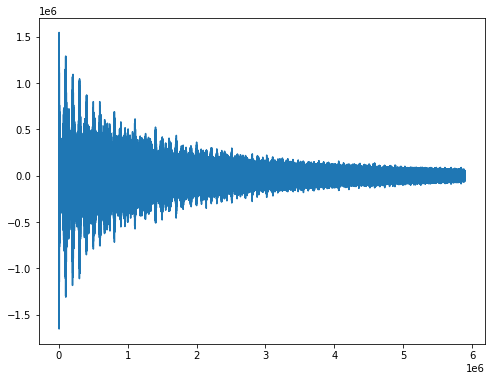

In [73]:
plt.plot(UbiSpec.trans)
plt.savefig("/results/Panel1-1.svg")

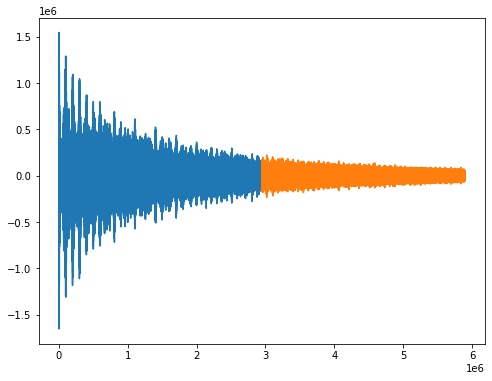

In [74]:
plt.plot(np.arange(UbiSpec.TrLen//2),UbiSpec.trans[0:UbiSpec.TrLen//2])
plt.plot(np.arange(UbiSpec.TrLen//2,UbiSpec.TrLen),UbiSpec.trans[UbiSpec.TrLen//2:UbiSpec.TrLen])

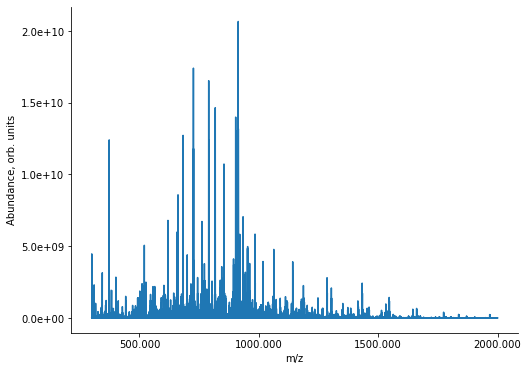

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [75]:
UbiSpec.plotmasskai(300,2000,fname="/results/Panel1-2.svg")

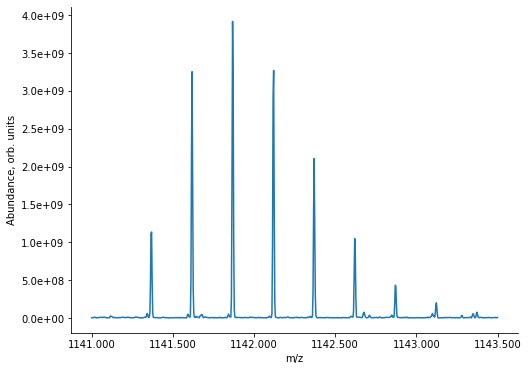

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [76]:
UbiSpec.plotmasskai(1141,1143.5,fname="/results/Panel1-3.svg")

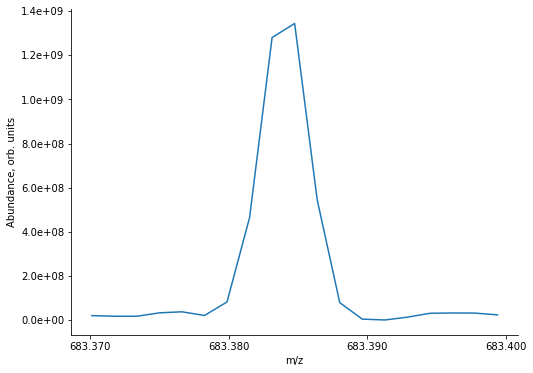

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [77]:
UbiSpec.plotmasskai(683.37,683.4,fname="/results/Panel1-4.svg")

### Figure 2 and Suplementary Figure 1

In [87]:
UbiSpec.UsualProcessing()

In [92]:
_,coverSet,cover=UbiSpec.Products(sequence="MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG")

In [93]:
coverSet

[[],
 [],
 [],
 ['b3 1+'],
 ['a4 1+', 'b4 1+'],
 ['a5 1+', 'b5 1+', 'c5 1+'],
 ['b6 2+', 'b6 1+'],
 ['b7 1+'],
 ['a8 2+', 'a8 1+', 'b8 2+', 'b8 1+'],
 ['a9 2+', 'a9 1+', 'b9 2+', 'b9 1+'],
 ['b10 1+', 'c10 2+', 'c10 1+'],
 ['b11 2+', 'b11 1+', 'c11 1+'],
 ['b12 2+', 'b12 1+', 'c12 1+'],
 ['a13 2+', 'b13 2+', 'b13 1+'],
 ['a14 3+', 'a14 2+', 'b14 3+', 'b14 2+', 'b14 1+', 'c14 1+'],
 ['a15 3+', 'a15 2+', 'b15 3+', 'b15 2+', 'b15 1+', 'y61 7+'],
 ['a16 3+', 'a16 2+', 'b16 3+', 'b16 2+', 'b16 1+', 'y60 7+'],
 ['a17 3+', 'a17 2+', 'b17 3+', 'b17 2+', 'b17 1+'],
 ['a18 2+',
  'b18 3+',
  'b18 2+',
  'b18 1+',
  'y58 9+',
  'y58 8+',
  'y58 7+',
  'y58 6+',
  'z58 9+'],
 ['y57 7+'],
 ['b20 2+', 'y56 8+', 'y56 7+', 'y56 6+'],
 ['y55 8+', 'y55 7+'],
 ['b22 2+', 'y54 8+', 'y54 7+', 'y54 6+', 'y54 5+'],
 ['b23 2+', 'y53 8+', 'y53 7+', 'y53 6+', 'y53 5+'],
 ['y52 8+', 'y52 7+', 'y52 6+', 'z52 8+', 'z52 7+', 'z52 6+'],
 ['b25 2+', 'y51 7+', 'y51 6+'],
 ['y50 7+', 'y50 6+', 'y50 5+'],
 ['y49 7+', 'y

In [94]:
cover

0.92

In [96]:
UbiSpec.PeakstoClusters()

In [98]:
len(UbiSpec.RPeaks[UbiSpec.RPeaks["Ions"]!=""])

1167

In [99]:
len(UbiSpec.Clusters[UbiSpec.Clusters["Ions"]!=""])

212

In [100]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks['Ions']!=""]

In [101]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["number"]==0]

In [102]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["Correlation"]>0.98]

In [103]:
UbiSpec.RPeaks=UbiSpec.RPeaks[~UbiSpec.RPeaks["issues"]]

In [108]:
_=UbiSpec.TDACalc()

,m/z,Intensity,resolution,issues,cluster,number,rest,intensity,Mass,Charge,...,Ions,PPMError,Shift,TheorMass,Slope,Intercept,RSquare,Ratio,FWHM,FWHM Coeff
0,336.219280,6.134931e+07,235617.000000,False,143,0,0.000108,6.134931e+07,670.4239,2,...,y6,0.082451,0,670.423845,-2.028517,4.902530,-0.988961,3.958016,0.001427,1.257158
1,340.885709,6.461985e+08,241279.703125,False,150,0,0.000096,6.461985e+08,1019.6352,3,...,y9,-0.034899,0,1019.635236,-1.585853,6.976873,-0.999223,3.251067,0.001413,1.231739
2,373.190300,1.242558e+10,233241.078125,False,199,0,0.000023,1.242558e+10,372.1830,1,...,b3,-0.342904,0,372.183128,-0.705102,9.327137,-0.999796,1.728489,0.001600,1.222414
3,374.214745,4.155771e+07,228483.218750,False,201,0,0.000036,4.155771e+07,746.4149,2,...,b6,-0.026232,0,746.414920,-1.478049,4.211250,-0.923763,1.989147,0.001638,1.238192
4,378.580244,7.365858e+07,220029.546875,False,208,0,0.000103,7.365858e+07,1132.7188,3,...,y10,-0.441358,0,1132.719300,-2.013676,5.086413,-0.979811,3.410930,0.001721,1.264803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,1579.916452,2.039474e+07,103602.679688,False,2124,0,0.000275,2.039474e+07,1578.9089,1,...,c14,-4.966538,0,1578.916742,-0.473106,2.856840,-0.487728,1.221543,0.015250,1.297800
135,1675.974630,1.490847e+08,107425.664062,False,2192,0,0.000354,1.490847e+08,1674.9670,1,...,b15,-4.332607,0,1674.974257,-1.015279,5.140671,-0.967207,2.143494,0.015601,1.242142
136,1805.016248,9.635850e+07,99762.593750,False,2239,0,0.000372,9.635850e+07,1804.0086,1,...,b16,-4.573809,0,1804.016851,-1.693518,5.147122,-0.977280,3.616243,0.018093,1.273081
137,1904.083723,6.395316e+07,101279.820312,False,2271,0,0.000047,6.395316e+07,1903.0764,1,...,b17,-4.658496,0,1903.085266,-1.714450,4.788556,-0.986970,2.683335,0.018800,1.238083


In [111]:
FRes=UbiSpec.RPeaks[UbiSpec.RPeaks["RSquare"]<-0.85]

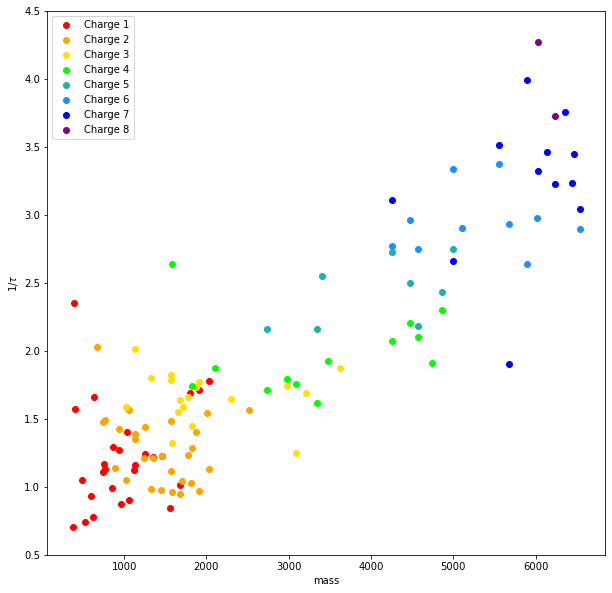

In [112]:
Counter=0
plt.rcParams["figure.figsize"] = (10,10)
for i in range(1,9):
    Yscat=-FRes["Slope"][FRes["Charge"]==i]
    Xscat=FRes["m/z"][FRes["Charge"]==i]*i
    plt.plot(Xscat,Yscat,"o",color=colors[i],label="Charge "+str(i))
plt.legend()
plt.xlabel("mass")
plt.ylabel(r"1/$\tau$")
#plt.xlim(800,860)
plt.ylim(0.5,4.5)
plt.savefig("/results/Panel2-1.svg")
plt.show()

In [113]:
UbiSpec.PeakstoClusters()

In [114]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks['Ions']!=""]

In [115]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks["Correlation"]>0.98]

In [116]:
UbiSpec.RPeaks=UbiSpec.RPeaks[~UbiSpec.RPeaks["issues"]]

In [117]:
UbiSpec.RPeaks=UbiSpec.RPeaks[UbiSpec.RPeaks.Intensity>1.0e08]

In [119]:
UbiSpec.TDACalc()

,m/z,Intensity,resolution,issues,cluster,number,rest,intensity,Mass,Charge,...,Ions,PPMError,Shift,TheorMass,Slope,Intercept,RSquare,Ratio,FWHM,FWHM Coeff
0,340.885709,6.461985e+08,241279.703125,False,150,0,0.000096,6.461985e+08,1019.6352,3,...,y9,-0.034899,0,1019.635236,-1.585853,6.976873,-0.999223,3.251067,0.001413,1.231739
1,341.220173,3.007582e+08,244628.937500,False,150,1,0.000135,3.007582e+08,1019.6352,3,...,y9,-0.034899,0,1019.635236,-1.589961,6.227196,-0.940514,4.117533,0.001395,1.220073
2,373.190300,1.242558e+10,233241.078125,False,199,0,0.000023,1.242558e+10,372.1830,1,...,b3,-0.342904,0,372.183128,-0.705102,9.327137,-0.999796,1.728489,0.001600,1.222414
3,374.193646,1.972783e+09,235001.218750,False,199,1,0.000015,1.972783e+09,372.1830,1,...,b3,-0.342904,0,372.183128,-0.845648,7.585471,-0.998761,1.989504,0.001592,1.215215
4,385.753269,3.492118e+08,224314.703125,False,220,0,0.000085,3.492118e+08,769.4919,2,...,y7,-0.466554,0,769.492259,-1.492609,6.305540,-0.996121,3.386155,0.001720,1.240856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,1563.895280,2.102023e+08,108530.632812,False,2109,1,0.001249,2.102023e+08,1561.8834,1,...,b14,-4.348996,0,1561.890193,-1.153688,5.580529,-0.986159,2.574061,0.014410,1.262498
562,1675.974630,1.490847e+08,107425.664062,False,2192,0,0.000354,1.490847e+08,1674.9670,1,...,b15,-4.332607,0,1674.974257,-1.015279,5.140671,-0.967207,2.143494,0.015601,1.242142
563,1676.978170,1.271138e+08,105360.921875,False,2192,1,0.000539,1.271138e+08,1674.9670,1,...,b15,-4.332607,0,1674.974257,-1.352125,5.204731,-0.970992,2.686987,0.015917,1.258065
564,2033.125965,1.098032e+08,97172.039062,False,2295,0,-0.000511,1.098032e+08,2032.1192,1,...,b18,-4.261414,0,2032.127860,-1.781703,5.359344,-0.988488,4.319183,0.020923,1.245208


In [120]:
FRes=UbiSpec.RPeaks[UbiSpec.RPeaks["RSquare"]<-0.85]

In [122]:
FWHMstd=np.std(FRes["FWHM Coeff"])

In [123]:
FWHMmean=np.mean(FRes["FWHM Coeff"])

In [124]:
FRes=FRes[(FRes["FWHM Coeff"]<FWHMmean+3*FWHMstd) & (FRes["FWHM Coeff"]>FWHMmean-3*FWHMstd)]

In [131]:
lr=LogisticReg(FRes,FWHM=True)
Y,Y_Distr=lr.Apply(FRes)

Charge 	Peaks 	 Mean 	 Variance
1 	46 	 1.230 	 0.348
2 	80 	 2.292 	 0.504
3 	60 	 2.951 	 0.628
4 	65 	 4.184 	 0.929
5 	54 	 5.242 	 0.781
6 	79 	 5.876 	 0.699
7 	101 	 6.699 	 0.556
8 	36 	 7.616 	 0.451
Resolution: 5.55


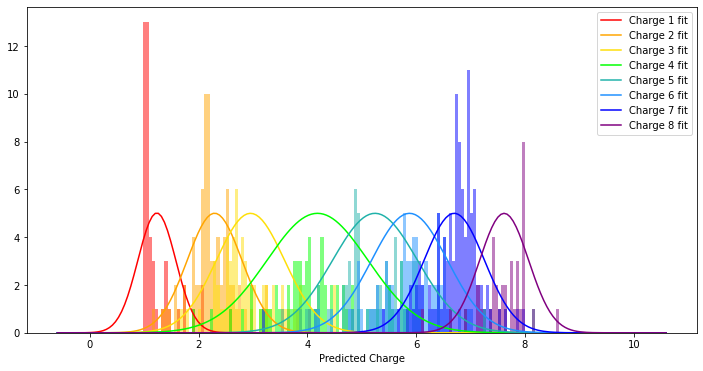

In [137]:
ShowRes(Y,FRes["Charge"],MaxCharge=8,GaussianHeght=5,fname="/results/Panel2-2.svg")

In [133]:
lrm=MassLogisticReg(FRes,FWHM=True)
FRes.reset_index(inplace=True,drop=True)
Y_pred_mass,Y_pred_Distr=lrm.Apply(FRes)

Charge 	Peaks 	 Mean 	 Variance
1 	46 	 1.163 	 0.302
2 	80 	 2.153 	 0.496
3 	60 	 3.056 	 0.566
4 	65 	 4.204 	 0.803
5 	54 	 5.275 	 0.677
6 	79 	 5.912 	 0.683
7 	101 	 6.739 	 0.570
8 	36 	 7.704 	 0.415
Resolution: 6.02


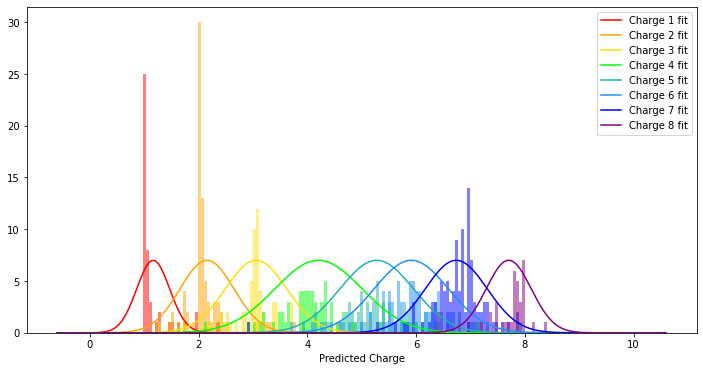

In [138]:
ShowRes(Y_pred_mass,FRes["Charge"],MaxCharge=8,GaussianHeght=7,fname="/results/PanelS1-1.svg")

### Figure 3

In [139]:
F3Peaks = UbiSpec.peaks[(UbiSpec.peaks["m/z"]>811.)&(UbiSpec.peaks["m/z"]<813.5)]

In [140]:
F3Peaks=UbiSpec.TDACalc(Peaks=F3Peaks)

,m/z,Intensity,resolution,issues,Slope,Intercept,RSquare,Ratio,FWHM,FWHM Coeff
0,811.000369,11073826.0,112295.335938,False,-1.853775,3.106648,-0.564229,2.008479,0.007222,1.536173
1,811.015810,15308393.0,149533.843750,False,-1.232750,3.376879,-0.449407,0.947460,0.005424,1.269191
2,811.026462,16383418.0,84767.554688,False,-0.797391,3.065152,-0.388990,0.831827,0.009568,1.852885
3,811.038615,18650652.0,108112.375000,False,-0.548818,2.936804,-0.207647,0.886878,0.007502,1.575516
4,811.061247,24789634.0,98952.312500,True,-0.630289,3.144901,-0.235629,1.257322,0.008196,1.671280
...,...,...,...,...,...,...,...,...,...,...
140,813.431740,59008872.0,149421.734375,True,-2.276037,6.010942,-0.708846,2.510893,0.005444,1.268567
141,813.436310,90308640.0,137862.859375,True,-0.965857,5.518069,-0.506033,2.613813,0.005900,1.338509
142,813.444657,210898048.0,120966.281250,True,-1.656107,6.022179,-0.846966,2.669228,0.006725,1.460398
143,813.469686,67155960.0,97546.859375,False,-1.486775,4.679676,-0.535977,2.637422,0.008339,1.685627


In [142]:
lr=MassLogisticReg(FRes,FWHM=True)
F3Peaks=lr.Estimate(F3Peaks)

-0.875 7.875


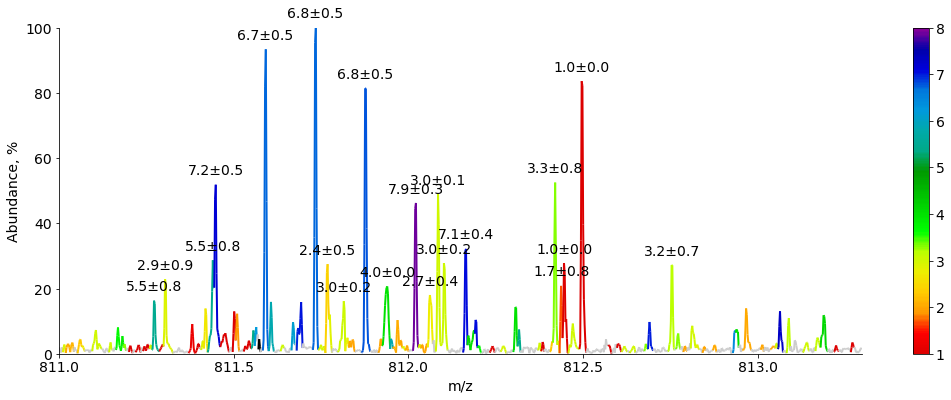

In [150]:
UbiSpec.RainbowSpectrum(811,813.3,F3Peaks,maxCharge=8,svg=True,Name="/results/Panel3-1")

In [144]:
lowPeaks=F3Peaks[F3Peaks["Aver"]<4.]
highPeaks=F3Peaks[F3Peaks["Aver"]>5.]
midPeaks=F3Peaks[F3Peaks["Aver"]<6.]
midPeaks=midPeaks[midPeaks["Aver"]>3.]

In [152]:
plt.rcParams["figure.figsize"] = (8,5)

In [153]:
F3MaxInt=np.max(F3Peaks["Intensity"])

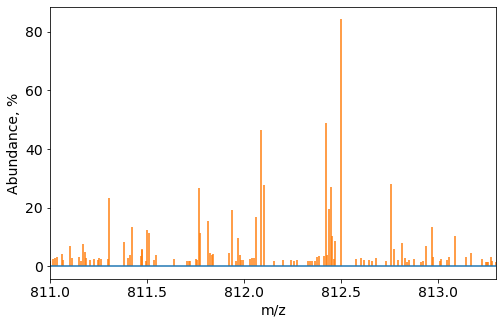

In [154]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(lowPeaks["m/z"],(lowPeaks["Intensity"]/F3MaxInt)*100.,"C1",markerfmt=" ", basefmt="C0")
plt.savefig("/results/Panel3-2.svg")
plt.show()

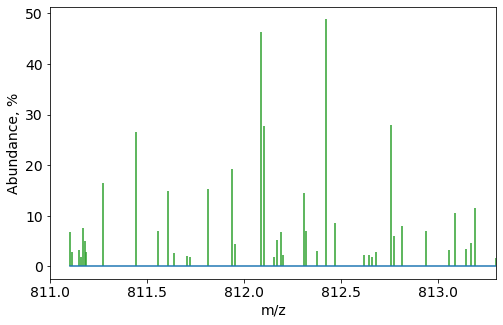

In [155]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(midPeaks["m/z"],(midPeaks["Intensity"]/F3MaxInt)*100.,"C2",markerfmt=" ", basefmt="C0")
plt.savefig("/results/Panel3-3.svg")
plt.show()

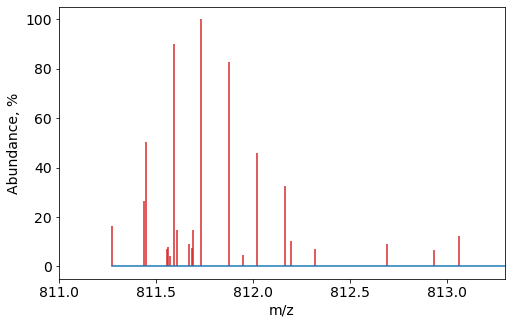

In [156]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.set_xlim(811.,813.3)
ax.stem(highPeaks["m/z"],(highPeaks["Intensity"]/F3MaxInt)*100.,"C3",markerfmt=" ", basefmt="C0")
plt.savefig("/results/Panel3-4.svg")
plt.show()

### Figure 4

In [158]:
myhf=h5py.File("/data/CAH_MYO_NEO_averaged_transient_1.0s.h5","r")

In [159]:
CAHSingle=FullSpectrum((myhf["0"][:])[1000:4100000])

In [160]:
CAHSingle.PeakPick(119,2600,sn=3.)
CAHSingle.CheckIssues()
CAHSingle.RunHardKlor(charge_min=1,charge_max=40)

In [161]:
CAHSingle.Clusters.at[18,"Mass"]=29006.48
CAHSingle.Clusters.at[18,"Charge"]=34
CAHSingle.Clusters.at[47,"Mass"]=29006.48
CAHSingle.Clusters.at[47,"Charge"]=28
CAHSingle.Clusters.at[55,"Mass"]=29006.48
CAHSingle.Clusters.at[55,"Charge"]=26
CAHSingle.Clusters=CAHSingle.Clusters.drop([19,48])

In [162]:
_ = CAHSingle.TDACalc(Peaks=CAHSingle.peaks)

In [170]:
CAHSingle.peaks

,m/z,Intensity,resolution,issues,Slope,Intercept,RSquare,Ratio,FWHM,FWHM Coeff,Aver,Sigma
0,121.187087,14942.633789,202199.765625,False,2.864288,-5.978208,0.657735,0.942453,0.000599,1.956235,1.000000,0.000180
1,121.190207,19405.539062,142267.265625,False,1.625097,-4.722872,0.362756,1.022665,0.000852,2.472811,1.001306,0.036116
2,122.393172,11865.750000,177428.453125,False,1.918244,-5.690652,0.529247,0.989432,0.000690,2.127265,1.000002,0.001368
3,123.236673,12012.008789,183907.687500,False,1.814318,-5.355702,0.433263,1.055415,0.000670,2.072258,1.000004,0.001884
4,125.384429,11657.380859,170463.687500,False,1.034177,-5.490046,0.272061,1.226290,0.000736,2.167297,1.000804,0.028338
...,...,...,...,...,...,...,...,...,...,...,...,...
636,1713.864026,50831.425781,74767.242188,False,0.700445,-3.539853,0.296738,1.576326,0.022923,1.569839,1.475074,0.499378
637,1780.499988,18828.687500,48751.753906,False,1.002899,-4.466721,0.264045,1.516870,0.036522,2.061265,1.006518,0.080473
638,2343.934528,18149.503906,44581.167969,False,1.396708,-4.757482,0.323332,1.155682,0.052577,1.996248,1.001086,0.032930
639,2344.098697,19843.103516,46863.804688,False,3.210694,-5.677645,0.756811,0.689834,0.050019,1.930850,1.000001,0.000780


In [168]:
CAHSingle.Clusters.head(40)

,Mass,Charge,Abundance,Base Peak,Interval,Correlation
0,1744.3646,7,27347360,250.2023,250.0336-251.0540,0.9270
1,250.0959,1,143416720,251.1032,250.9725-253.2930,0.9993
2,250.1435,1,109707600,251.1508,250.9725-253.2930,0.9997
3,251.1275,1,50028624,252.1348,252.0274-254.2632,0.9915
4,2514.4808,10,31059504,252.6559,252.3436-253.1664,0.9867
5,1510.9164,6,24641598,252.8267,252.7086-253.7892,0.9993
6,1767.6049,7,24777122,253.5223,253.4140-254.3926,0.9293
7,253.1431,1,301511584,254.1504,253.9746-256.3162,0.9992
8,2026.0798,8,139584400,254.3926,254.1504-254.9976,0.9874
9,254.1999,1,62429548,255.2072,255.0365-257.3868,0.9843


In [169]:
CAHSingle.Clusters

,Mass,Charge,Abundance,Base Peak,Interval,Correlation
0,1744.3646,7,27347360,250.2023,250.0336-251.0540,0.9270
1,250.0959,1,143416720,251.1032,250.9725-253.2930,0.9993
2,250.1435,1,109707600,251.1508,250.9725-253.2930,0.9997
3,251.1275,1,50028624,252.1348,252.0274-254.2632,0.9915
4,2514.4808,10,31059504,252.6559,252.3436-253.1664,0.9867
...,...,...,...,...,...,...
2318,2391.4356,1,28518742,2393.4456,2392.1787-2398.7551,0.9569
2319,2417.1574,1,34875532,2418.1650,2417.1772-2424.3540,0.9866
2320,2439.5996,1,29419014,2442.6118,2440.4929-2446.8804,0.9428
2321,7324.7350,3,79166696,2443.9224,2442.1560-2446.8804,0.9366


In [163]:
CAHSingle.PeakstoClusters()

In [164]:
CAHlr=LogisticReg(CAHSingle.RPeaks,NoMZ=True,FWHM=True)
Y,Y_Distr=CAHlr.Apply(CAHSingle.RPeaks)

Charge 	Peaks 	 Mean 	 Variance
1 	10 	 1.269 	 0.180
2 	6 	 1.552 	 0.277
7 	2 	 1.000 	 0.000
Resolution: 97.35


/opt/conda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


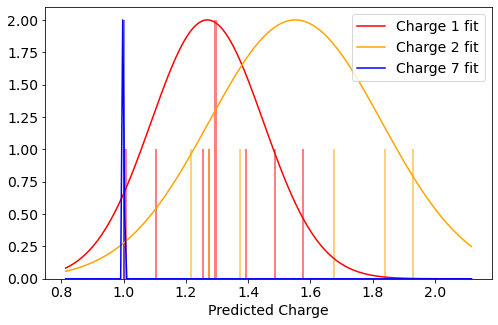

In [165]:
ShowRes(Y,CAHSingle.RPeaks["Charge"],MaxCharge=35,GaussianHeght=2)

In [166]:
CAHSingle.peaks=CAHlr.Estimate(CAHSingle.peaks)

-4.25 38.25


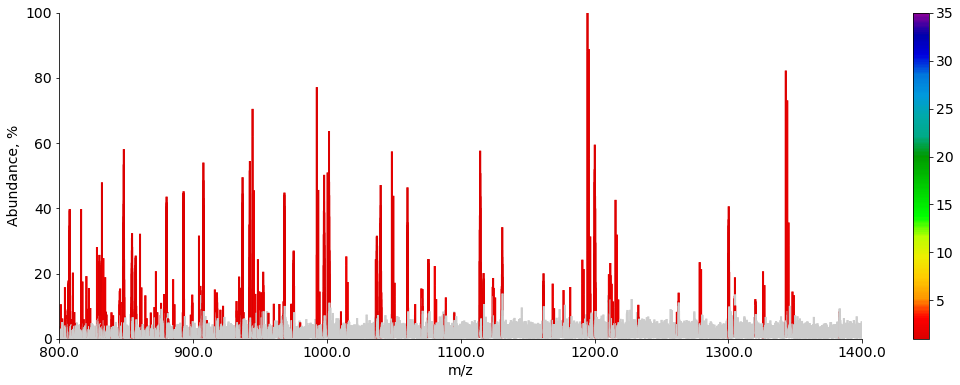

In [167]:
CAHSingle.RainbowSpectrum(800,1400,CAHSingle.peaks,maxCharge=35,LabelThres=1.,svg=True,Name="Panel4-1")

In [102]:
F4Peaks = UbiSpec.peaks[(UbiSpec.peaks["m/z"]>851) & (UbiSpec.peaks["m/z"]<854)]

In [103]:
F4Peaks

,m/z,Intensity,resolution,issues
16870,851.032754,9606249.0,55483.792969,False
16871,851.051289,52104052.0,139406.593750,False
16872,851.064619,18111110.0,155385.812500,False
16873,851.079168,12037622.0,112764.273438,False
16874,851.124609,13811067.0,93195.531250,False
...,...,...,...,...
17000,853.900485,8895056.0,129270.226562,True
17001,853.936833,41210568.0,150765.968750,True
17002,853.945083,11787639.0,138793.625000,True
17003,853.964019,34028276.0,83107.250000,False


In [104]:
F4Peaks=UbiSpec.SRCalc(Peaks=F4Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



0 LinregressResult(slope=-0.007203352284777431, intercept=2.079649822744295, rvalue=-0.002507792631379512, pvalue=0.8872324767669547, stderr=0.05079283310636913)
1 LinregressResult(slope=-3.0365606867606636, intercept=5.330295114521262, rvalue=-0.8796345952783382, pvalue=0.0, stderr=0.029035411743292227)
2 LinregressResult(slope=-2.437404857055463, intercept=4.656418892293926, rvalue=-0.8010475867915022, pvalue=0.0, stderr=0.03220826461782511)
3 LinregressResult(slope=-1.470300614290852, intercept=3.311150160199077, rvalue=-0.5045658600772772, pvalue=2.5654794079145004e-206, stderr=0.04448848469046374)
4 LinregressResult(slope=-1.9027669973227805, intercept=3.7561905936371263, rvalue=-0.7405969109401461, pvalue=0.0, stderr=0.03052819732432634)
5 LinregressResult(slope=-1.322231598726283, intercept=2.9575898075327025, rvalue=-0.47716834660764207, pvalue=1.1208032008749225e-181, stderr=0.043061842505851766)
6 LinregressResult(slope=0.14746896184520542, intercept=1.7811004505915626, rvalu

In [105]:
F4Peaks=lr.Estimate(F4Peaks)

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-0.875 7.875


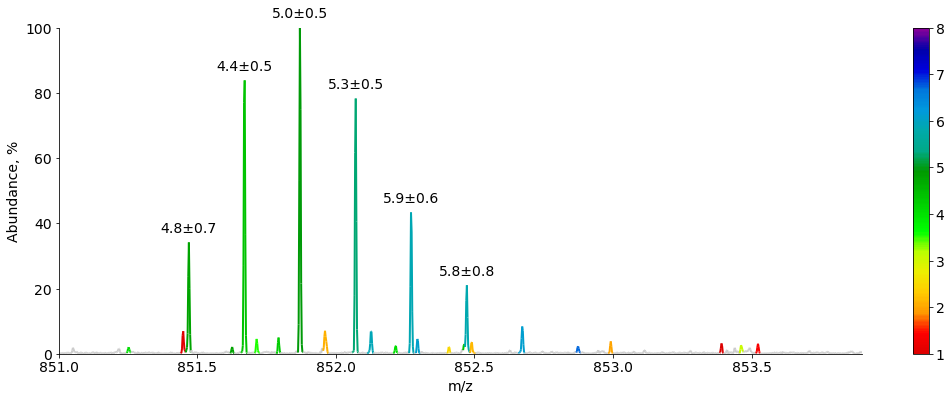

In [106]:
UbiSpec.RainbowSpectrum(851,853.9,F4Peaks,LabelThres=0.1,Name="Panel4-2",svg=True)

In [107]:
omega=50
resolution=100
tau=0.01
s=np.arange(omega*resolution*2*np.pi)/resolution

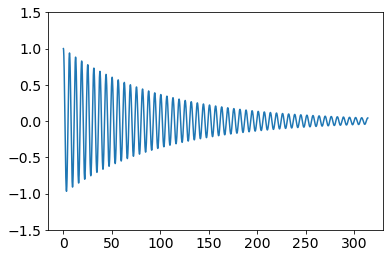

In [108]:
plt.rcParams["figure.figsize"] = (6,4)
plt.ylim(top=1.5, bottom=-1.5)
exp_sig1=np.cos(s)*np.exp(-(s*tau))
exp_sig2=np.cos(s*1.03)*np.exp(-(s*tau))
plt.plot(s,exp_sig1)
plt.savefig("Panel4-3.svg")

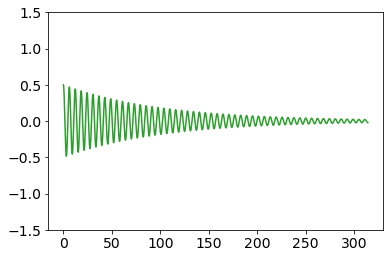

In [109]:
plt.ylim(top=1.5, bottom=-1.5)
plt.plot(s,exp_sig2*0.5,color="C2")
plt.savefig("Panel4-4.svg")

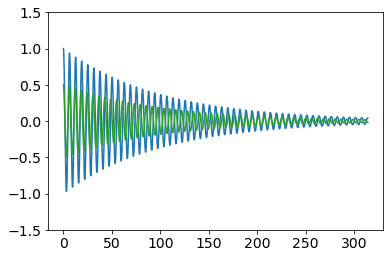

In [110]:
plt.ylim(top=1.5, bottom=-1.5)
plt.plot(s,exp_sig1,color="C0")
plt.plot(s,exp_sig2*0.5,color="C2")
plt.savefig("Panel4-5.svg")

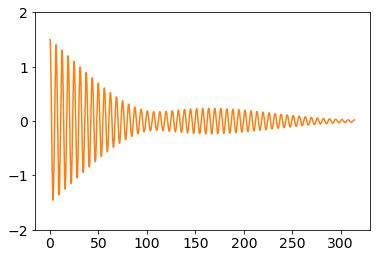

In [111]:
plt.ylim(top=2.0, bottom=-2.0)
plt.plot(s,exp_sig1+exp_sig2*0.5,color="C1")
plt.savefig("Panel4-6.svg")

In [112]:
SimTransient,IsoDistr=IsoSim("C121H201N33O36S1",4,4,1.7)

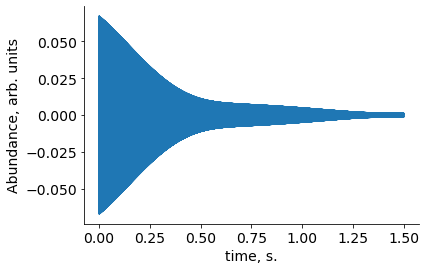

In [113]:
fig, ax = plt.subplots()
ax.set_xlabel("time, s.")
ax.set_ylabel("Abundance, arb. units")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)        
plt.plot(np.arange(6000000)/4000000.0,SimTransient)
plt.savefig("Panel4-7.svg")  

In [114]:
IsoDistr["Abu"]=100.*(IsoDistr["Prob"]/np.sum(IsoDistr["Prob"]))

C:\Users\yaros\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


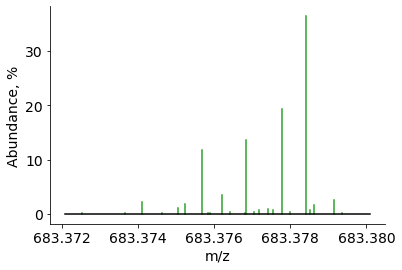

In [115]:
fig, ax = plt.subplots()
ax.set_xlabel("m/z")
ax.set_ylabel("Abundance, %")
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.3f'))
ax.locator_params(axis='x',nbins=5)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)        

#ax.set_xlim(811.,813.3)
ax.stem(IsoDistr["m/z"],IsoDistr["Abu"],"C2",markerfmt=" ", basefmt="black")
plt.savefig("Panel4-8.svg")

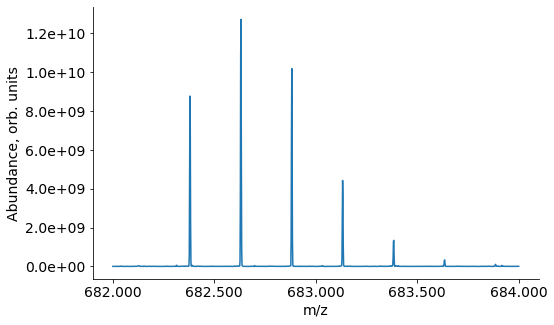

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [116]:
plt.rcParams["figure.figsize"] = (8,5)
UbiSpec.plotmasskai(682,684,fname="Panel4-9.svg")

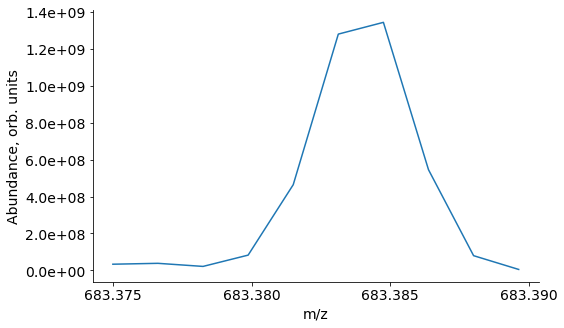

<module 'matplotlib.pyplot' from 'C:\\Users\\yaros\\Anaconda3\\envs\\tf2\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [117]:
UbiSpec.plotmasskai(683.375,683.39)